### 1 - Customer Segmentation - RFM Analysis ###

#### 1.1 - Data preparation - Loading and basic transformations ####

In [1]:
# Import packages to data analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.pyplot import figure

In [2]:
# Import data to analyse

df = pd.read_csv("purchases.csv", sep=';')
df.head()

C:\SalsaDocumentacao\Python\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CodSalsaStar,Data,Fatura,Talao,EncomendaSAP,OrderRef,EncomendaSite,CodTipoDocumento,TipoDocumento,Loja,MercadoLoja,RefCorPerna,Material,Familia,Qtd,ValEfetivo,LojaOmnicanal
0,100000000000217,20180106,6.001096e+09,101000122644,NaN,NaN,NaN,ZP06,Venda,2001 - SALSA NORTESHOPPING,PORTUGAL,1.184778e+09,"EVEREST CASACO NYLO, MARINHO ORIGINAL, M",BLUSÕES E CASACOS,1.0,89.40,Não Definido
1,100000000000217,20180507,6.001295e+09,101000127094,NaN,NaN,NaN,ZP06,Venda,2001 - SALSA NORTESHOPPING,PORTUGAL,1.199409e+11,"CLASH SKINNY 1ST RE, MEDIUM DARK, 30, 32",JEANS E CALÇAS,1.0,129.00,Não Definido
2,100000000000217,20180507,6.001295e+09,101000127094,NaN,NaN,NaN,ZP56,Venda,2001 - SALSA NORTESHOPPING,PORTUGAL,NaN,OFERTA OCULOS DE SOL,NaN,0.0,0.00,Não Definido
3,100000000000217,20180521,6.001316e+09,101000127818,NaN,NaN,NaN,ZP06,Venda,2001 - SALSA NORTESHOPPING,PORTUGAL,1.194148e+09,"ITALY POLO ESTAMPADO AL, AZUL PARAÍSO, S","CAMISOLAS, T-SHIRTS, PÓLOS E TOPS",1.0,44.91,Não Definido
4,100000000000217,20181021,6.001625e+09,211000134331,NaN,NaN,NaN,ZP06,Venda,2012 - VILA DO CONDE PORTO FASHION OUTLET,PORTUGAL,1.181568e+09,"VANCOUVER CAMISOLA, MARINHO ORIGINAL, M",CAMISOLAS E CASACOS TRICOTADOS,1.0,46.95,Não Definido


In [4]:
# Sample the dataset (to perform better and quick anlalysis)

df_sample = df.sample(500000, random_state = 42)
df_sample = df_sample[df_sample["TipoDocumento"] == "Venda"]
print(df_sample["TipoDocumento"])

1045386    Venda
728614     Venda
1335578    Venda
930976     Venda
613630     Venda
           ...  
519158     Venda
1077638    Venda
719531     Venda
1387961    Venda
1112460    Venda
Name: TipoDocumento, Length: 444097, dtype: object


In [5]:
# Create the RFM table 
# Dealing with purchase date

df_sample["Data"] = df_sample['Data'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_sample["Data"]

1045386   2020-07-14
728614    2019-03-09
1335578   2019-03-30
930976    2020-11-29
613630    2018-06-16
             ...    
519158    2018-09-24
1077638   2019-01-13
719531    2018-08-14
1387961   2018-08-14
1112460   2019-05-15
Name: Data, Length: 444097, dtype: datetime64[ns]

In [6]:
# Create TotalSum colummn
df_sample["TotalSum"] = df_sample["Qtd"] * df_sample["ValEfetivo"]
df_sample["TotalSum"]

1045386    17.57
728614     29.95
1335578    39.95
930976     63.96
613630     14.90
           ...  
519158     18.13
1077638    77.86
719531      9.95
1387961    39.38
1112460    35.26
Name: TotalSum, Length: 444097, dtype: float64

In [7]:
# Create date variable that records recency
import datetime
snapshot_date = max(df_sample.Data) + datetime.timedelta(days=1)
snapshot_date

Timestamp('2021-04-01 00:00:00')

In [8]:
max(df_sample.Data) + datetime.timedelta(days=1)

Timestamp('2021-04-01 00:00:00')

In [9]:
# Aggregate data by each customer
customers = df_sample.groupby(['CodSalsaStar']).agg({
    'Data': lambda x: (snapshot_date - x.max()).days,
    'Talao': 'count',
    'TotalSum': 'sum'})

In [10]:
# Rename columns
customers.rename(columns = {'Data': 'Recency',
                            'Talao': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [11]:
customers = customers[customers["MonetaryValue"] < 150]

In [12]:
print(customers)

               Recency  Frequency  MonetaryValue
CodSalsaStar                                    
100014             748          1     142.870000
100024             852          4     105.975065
400035            1090          1      79.900000
400074             860          2     121.830000
400127             628          2      64.900000
...                ...        ...            ...
WD00000357363      113          1     144.040000
WD00000367473     1020          2      72.280000
WRK0000003471     1183          1      12.930000
WRK0000011397     1186          0      19.990000
WRK0000012523     1114          1      21.540000

[23723 rows x 3 columns]


In [13]:
customers['MonetaryValue'] = customers['MonetaryValue'].astype(np.int64)
print(customers)

               Recency  Frequency  MonetaryValue
CodSalsaStar                                    
100014             748          1            142
100024             852          4            105
400035            1090          1             79
400074             860          2            121
400127             628          2             64
...                ...        ...            ...
WD00000357363      113          1            144
WD00000367473     1020          2             72
WRK0000003471     1183          1             12
WRK0000011397     1186          0             19
WRK0000012523     1114          1             21

[23723 rows x 3 columns]


In [14]:
# Example of data validation: CustomerID -> 200104
df_sample[df_sample["CodSalsaStar"] == 200104]

,CodSalsaStar,Data,Fatura,Talao,EncomendaSAP,OrderRef,EncomendaSite,CodTipoDocumento,TipoDocumento,Loja,MercadoLoja,RefCorPerna,Material,Familia,Qtd,ValEfetivo,LojaOmnicanal,TotalSum
24037,200104,2019-01-03,6.001846e+09,1911000033794,NaN,NaN,NaN,ZP06,Venda,2044 - SALSA CHIADO,PORTUGAL,1.204798e+09,"DENMARK CAMISA XADREZ R, AZUL INTENSO, L",CAMISAS E TÚNICAS,0.024311,0.97,Não Definido,0.023582
24044,200104,2020-12-07,6.700421e+09,111000129794,NaN,NaN,NaN,ZP06,Venda,2002 - SALSA VASCO DA GAMA,PORTUGAL,1.201699e+11,"WONDER PUSH UP CAPRI PREMI, DARK, 30, 30",JEANS E CALÇAS,1.000000,89.90,Não Definido,89.900000
24036,200104,2019-01-03,6.001846e+09,1911000033793,NaN,NaN,NaN,ZP06,Venda,2044 - SALSA CHIADO,PORTUGAL,1.201699e+11,"WONDER PUSH UP CAPRI PREMI, DARK, 29, 30",JEANS E CALÇAS,1.000000,71.92,Não Definido,71.920000
24035,200104,2019-01-03,6.001845e+09,1911000033792,NaN,NaN,NaN,ZP06,Venda,2044 - SALSA CHIADO,PORTUGAL,NaN,VALE ONLINE,NaN,1.000000,62.95,2044 - SALSA CHIADO,62.950000
24045,200104,2020-12-07,6.700421e+09,111000129794,NaN,NaN,NaN,ZP06,Venda,2002 - SALSA VASCO DA GAMA,PORTUGAL,1.219949e+11,"WONDER CAPRI, MEDDIUM LIGHT, 29, 30",JEANS E CALÇAS,1.000000,79.95,Não Definido,79.950000


In [15]:
# Print Table
customers

,Recency,Frequency,MonetaryValue
CodSalsaStar,,,
100014,748,1,142
100024,852,4,105
400035,1090,1,79
400074,860,2,121
400127,628,2,64
...,...,...,...
WD00000357363,113,1,144
WD00000367473,1020,2,72
WRK0000003471,1183,1,12


#### 1.2 - Data preparation - Some advanced transformations ####

##### 1.2.1 - Skewness #####

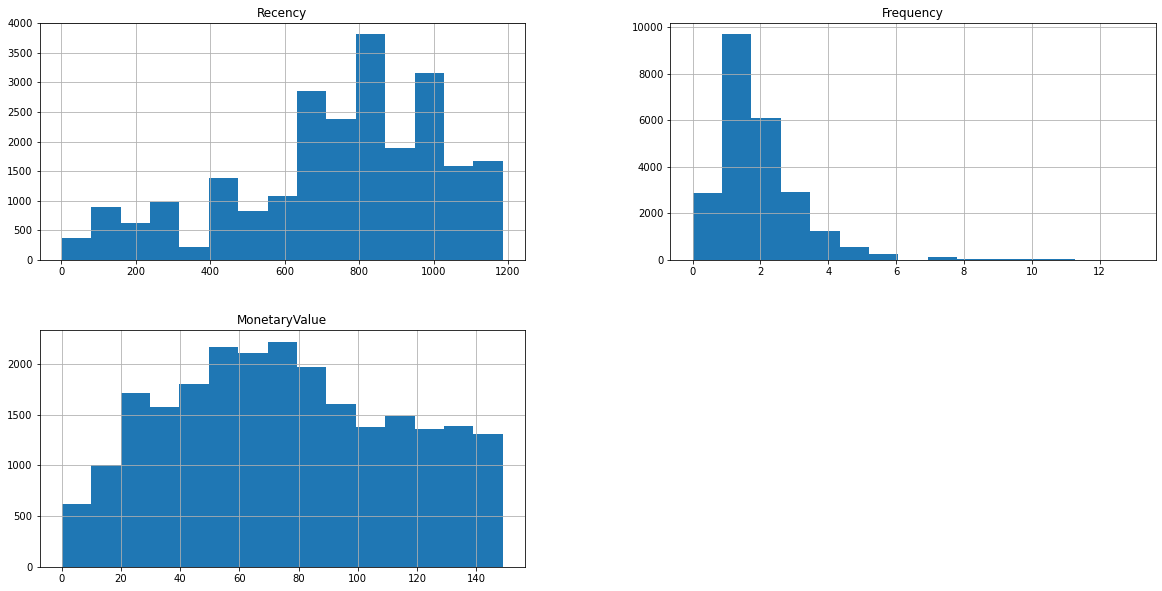

Recency: -0.7098918290672458
Frequency: 1.4690093037182326
MonetaryValue: 0.07368705349727304


In [16]:
# Before modelation we have to certified that that variables are good for the model
# Check skewness
variables = ["Recency", "Frequency", "MonetaryValue"]
customers[variables].hist(bins=15, figsize=(20, 10))
plt.show()
print("Recency: " + str(customers.Recency.skew()) + "\n"
      "Frequency: " + str(customers.Frequency.skew()) + "\n"
      "MonetaryValue: " + str(customers.MonetaryValue.skew()))

In [17]:
# Dealing skewness -> Log transformation vs sqrt
##Recency
log = np.log(customers["Recency"])
print("Recency|log: " + str(log.skew()))

sqrt = np.sqrt(customers['Recency'])
print("Recency|sqrt: " + str(sqrt.skew()))

#Frequency
log2 = np.log(customers["Frequency"])
print("Frequency|log: " + str(log2.skew()))

sqrt2 = np.sqrt(customers['Frequency'])
print("Frequency|sqrt: " + str(sqrt2.skew()))

#MonetaryValue
log3 = np.log(customers["MonetaryValue"])
print("MonetaryValue|log: " + str(log3.skew()))

sqrt3 = np.sqrt(customers['MonetaryValue'])
print("MonetaryValue|sqrt: " + str(sqrt3.skew()))

# choose sqrt because has better results than log and than normal skewness

Recency|log: -2.8545190063691743
Recency|sqrt: -1.3609343614359308
Frequency|log: nan
Frequency|sqrt: -0.3944782887264434
MonetaryValue|log: nan
MonetaryValue|sqrt: -0.7224883569758482


C:\SalsaDocumentacao\Python\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


                 Recency  Frequency  MonetaryValue
CodSalsaStar                                      
100014         27.349589   1.000000      11.916375
100024         29.189039   2.000000      10.246951
400035         33.015148   1.000000       8.888194
400074         29.325757   1.414214      11.000000
400127         25.059928   1.414214       8.000000
...                  ...        ...            ...
WD00000357363  10.630146   1.000000      12.000000
WD00000367473  31.937439   1.414214       8.485281
WRK0000003471  34.394767   1.000000       3.464102
WRK0000011397  34.438351   0.000000       4.358899
WRK0000012523  33.376639   1.000000       4.582576

[23723 rows x 3 columns]


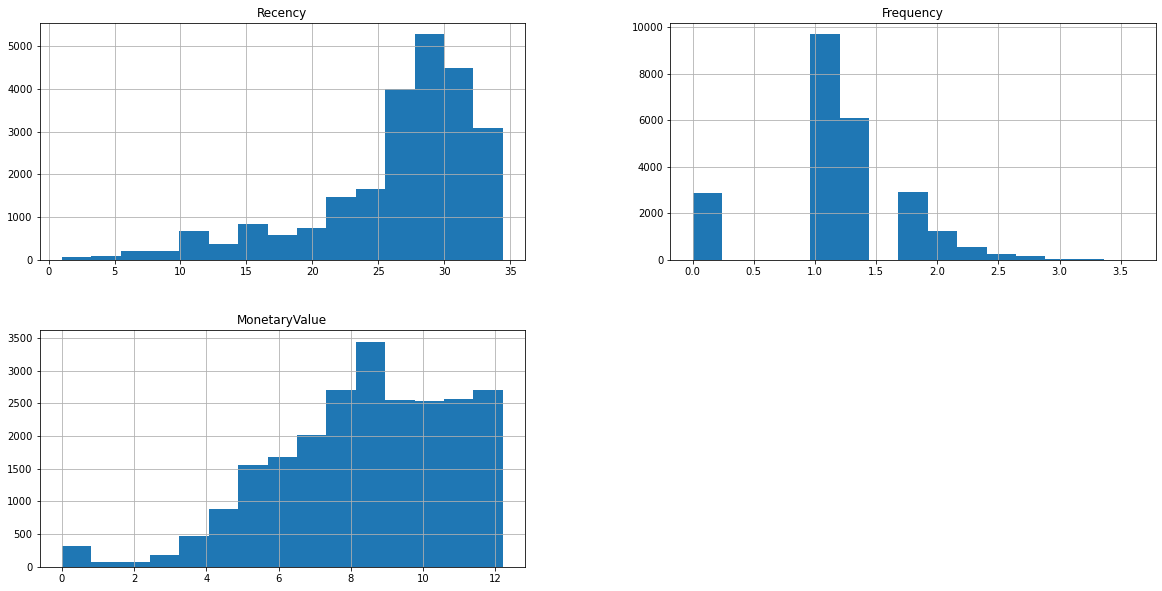

Recency: -1.3609343614359308
Frequency: -0.3944782887264434
MonetaryValue: -0.7224883569758482


In [18]:
# Give values to the variables
customers["Recency"] = np.sqrt(customers['Recency'])
customers["Frequency"] = np.sqrt(customers['Frequency'])
customers["MonetaryValue"] = np.sqrt(customers['MonetaryValue'])

# Print New Table
print(customers)

# Check skewness
variables = ["Recency", "Frequency", "MonetaryValue"]
customers[variables].hist(bins=15, figsize=(20, 10))
plt.show()
print("Recency: " + str(customers.Recency.skew()) + "\n"
      "Frequency: " + str(customers.Frequency.skew()) + "\n"
      "MonetaryValue: " + str(customers.MonetaryValue.skew()))

In [86]:
#customers = customers[customers["MonetaryValue"] < 100]

##### 1.2.2 - Normalization #####

In [19]:
# Normalization is required in order to have its variables with mean 0 and variance 1
# Initialize the Object
scaler = StandardScaler()

# Fit and Transform The Data
scaler.fit(customers)
customers_normalized = scaler.transform(customers)

# Array to dataframe
customers_normalized_frame = pd.DataFrame(customers_normalized)
#customers_normalized_frame
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0. -0. -0.]
[1. 1. 1.]


#### 1.3 - Data Modelation - K Means Alghorithm ####

In [81]:
# "K-Means algorithm is an unsupervised learning algorithm that uses the geometrical 
# principle to determine which cluster belongs to the data. By determine each centroid, 
# we calculate the distance to each centroid. Each data belongs to a centroid if it has
# the smallest distance from the other. It repeats until the next total of the distance 
# doesn’t have significant changes than before."

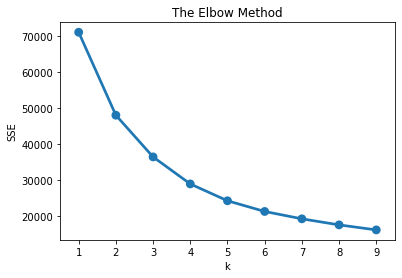

<Figure size 2400x800 with 0 Axes>

In [20]:
# Elbow Method is known to let people to know how muck clusters its needed

# "To make our clustering reach its maximum performance, we have to determine which hyperparameter
# fits to the data. To determine which hyperparameter is the best for our model and data
# , we can use the elbow method to decide."
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
figure(figsize=(30, 10), dpi=80)
plt.show()

# o elbow is the 4 (4 clusters needed)!

In [21]:
# Having the clusters number defined, now we have to fit the model

model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)

KMeans(n_clusters=4, random_state=42)

In [22]:
# Before clustering model aplication
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized

,Recency,Frequency,MonetaryValue,ID
0,0.134601,-0.315049,1.404571,100014
1,0.429338,1.433294,0.741066,100024
2,1.042400,-0.315049,0.201034,400035
3,0.451244,0.409138,1.040362,400074
4,-0.232274,0.409138,-0.151974,400127
...,...,...,...,...
23718,-2.544374,-0.315049,1.437807,WD00000357363
23719,0.869717,0.409138,0.040898,WD00000367473
23720,1.263457,-0.315049,-1.954747,WRK0000003471
23721,1.270441,-2.063392,-1.599113,WRK0000011397


In [23]:
# After clustering model aplication
df_normalized['Cluster'] = model.labels_
df_normalized

,Recency,Frequency,MonetaryValue,ID,Cluster
0,0.134601,-0.315049,1.404571,100014,1
1,0.429338,1.433294,0.741066,100024,1
2,1.042400,-0.315049,0.201034,400035,1
3,0.451244,0.409138,1.040362,400074,1
4,-0.232274,0.409138,-0.151974,400127,1
...,...,...,...,...,...
23718,-2.544374,-0.315049,1.437807,WD00000357363,0
23719,0.869717,0.409138,0.040898,WD00000367473,1
23720,1.263457,-0.315049,-1.954747,WRK0000003471,3
23721,1.270441,-2.063392,-1.599113,WRK0000011397,2


C:\SalsaDocumentacao\Python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


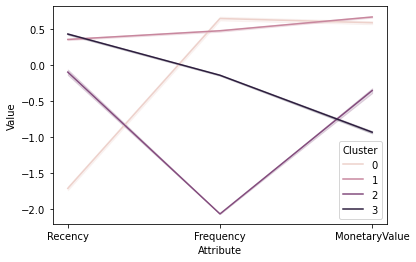

In [25]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')

# Visualize it
sns.lineplot('Attribute','Value', hue='Cluster', data=df_nor_melt)
plt.show()

#### 1.4 - Insights and Conclusions ####